# 유튜브 댓글 수집

In [1]:
from selenium import webdriver

In [2]:
# 크롬 웹드라이버 실행, 브라우저의 창을 최대화로 설정
from selenium.webdriver import ChromeOptions

options = ChromeOptions()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(options=options)

In [3]:
# 유튜브 영상 로드
# 페이지가 로드될 때까지 조금 기다려야 하므로 sleep() 함수 사용
import time
url = 'https://www.youtube.com/watch?v=-whqYLlpNAA'
driver.get(url)
time.sleep(3)

In [4]:
# 브라우저 높이를 계산해 변수에 저장
last_page_height = driver.execute_script(
    "return document.documentElement.scrollHeight"
)

In [5]:
# 댓글 영역이 보이도록 조금만 스크롤
driver.execute_script("window.scrollTo(0, 500)") 
time.sleep(1)

In [6]:
# 날짜 순으로 정렬하기 위해 [정렬 기준] > [최신순]을 클릭
from selenium.webdriver.common.by import By

driver.find_element(By.CSS_SELECTOR, "div#icon-label").click()
time.sleep(1)
driver.find_element(By.CSS_SELECTOR, "a[tabindex='-1'] div.item").click()

In [7]:
# 너무 많은 댓글이 수집되는 것을 방지하기 위해 최대 10페이지만 수집
page_count = 0

while True:
    scroll_script = "window.scrollTo(0, document.documentElement.scrollHeight)"
    driver.execute_script(scroll_script)
    time.sleep(3)
    scroll_height = "return document.documentElement.scrollHeight"
    new_page_height = driver.execute_script(scroll_height)

    if new_page_height== last_page_height:
        break
    last_page_height = new_page_height

    if page_count > 10:
        break
    else:
        page_count += 1

In [8]:
# 스크롤이 완료되면 현재 페이지 소스를 변수에 저장하고 웹드라이버를 종료
html_source = driver.page_source
driver.close()

In [9]:
# Beautiful Soup으로 HTML 문서 파싱
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_source, "html.parser")

In [10]:
# 댓글과 댓글 작성자 요소를 찾음
comments = soup.select("yt-attributed-string#content-text")
users = soup.select("a#author-text > span")

In [11]:
# 댓글과 작성자를 리스트로 만들기
comment_list = [comment.text.strip() for comment in	comments]
user_list = [user.text.strip() for user in users]

In [12]:
# 데이터프레임으로 만들고 파일에 저장 
import pandas as pd
import numpy as np
comment_df = pd.DataFrame(np.c_[user_list, comment_list],	
                          columns=["user",	"comment"])
comment_df.to_csv("comment.csv", encoding="utf-8-sig", index=False)

--------------------------------------------

# 유튜브 댓글 분석

In [13]:
import pandas as pd
comment_df = pd.read_csv("comment.csv", encoding='utf-8-sig')
comment_df.head()

,user,comment
0,@뿡-dls,노로바이러스 조심혀 망곰이
1,@누네띠네-k4i,ㅅㅂ
2,@손병호-k7p,0:11 계속 눌러보삼
3,@yeeun-t4g,뭘 아는 녀셕(나 보다 귀엽네…)
4,@주윤호-o7q,심쿵


In [14]:
# 정규표현식을 이용헤서 문자, 숫자, _로 이루어진 2자 이상 문자만 토큰화함
from nltk.tokenize import RegexpTokenizer
ret = RegexpTokenizer('[\w]{2,}')
comment_df['comment'] = comment_df["comment"].map(str)
comment_tokens = comment_df['comment'].map(ret.tokenize)

In [18]:
# 품사를 부착함
from nltk.tag import pos_tag
comment_tags = comment_tokens.map(pos_tag)

In [19]:
# 품사 태깅된 시리즈 객체를 리스트로 변환, 이렇게 만든 리스트는 2차원 구조
comment_list = comment_tags.values.tolist()

In [20]:
# 2차원 리스트를 1차원 리스트로 변환
from itertools import chain
comment_list = list(chain.from_iterable(comment_list))

In [21]:
# 정규표현식을 이용해서 명사만 추출함
import re
pattern = re.compile("NN?")
comment_nouns = [t[0] for t in comment_list if pattern.match(t[1])]

In [22]:
# 영문자 대/소문자를 구분하지 않게 하려고 모두 소문자로 변환
comment_nouns = [x.lower() for x in comment_nouns]
# map() 함수를 이용해서 리스트의 문자열을 소문자로 변환할 수 있음  # 위와 같음
# comment_nouns = list(map(lambda x: x.lower(), comment_nouns))

In [24]:
# 그래프에 한글을 지원하려면 폰트를 설정한 후 그래프를 그려야 함
from matplotlib import font_manager, rc
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

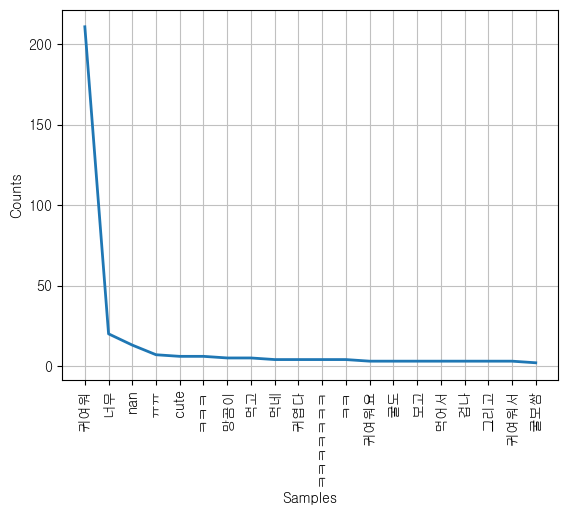

<Axes: xlabel='Samples', ylabel='Counts'>

In [25]:
# Text 객체로 만든 후 빈도수 그래프를 그림
from nltk import Text
comment_text = Text(comment_nouns)
comment_text.plot(20)

In [34]:
# 워드클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import Text

# Text 객체 생성
comment_text = Text(comment_nouns)

# nltk.Text 객체를 문자열로 변환 (띄어쓰기로 단어 연결)
comment_text_str = " ".join(comment_text)

# 워드 클라우드 생성
wordc = WordCloud(background_color="white", max_words=2000,
                  font_path=r'C:\Windows\Fonts\malgun.ttf',
                  relative_scaling=0.2)

wordc.generate(comment_text_str)  # 문자열을 전달해야 함

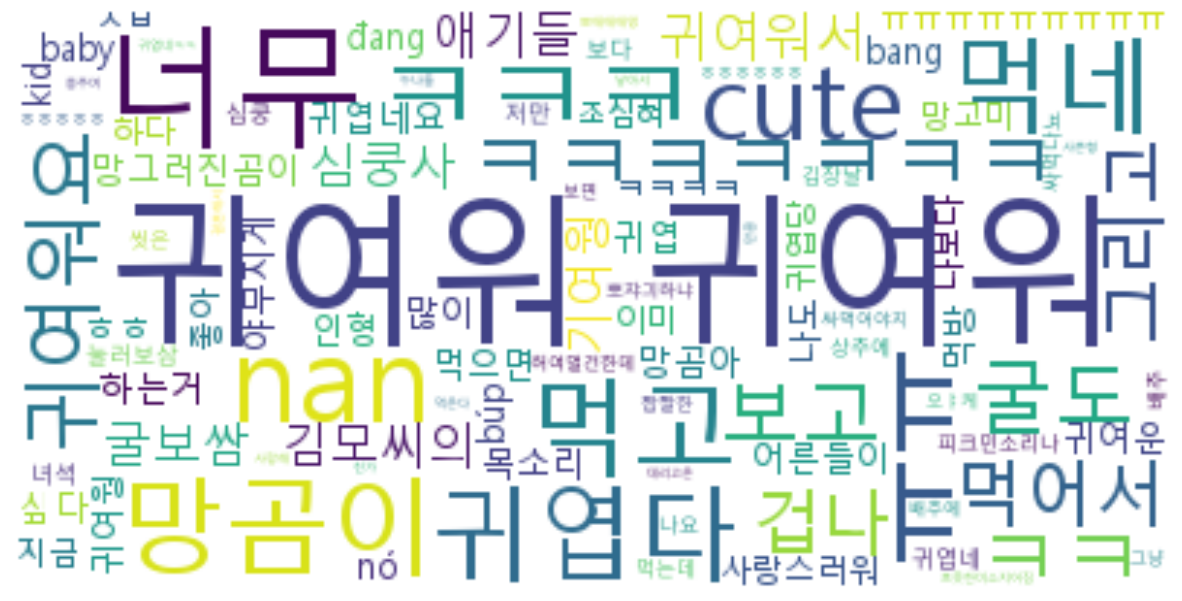

In [35]:
# 이미지의 크기를 가로 15인치, 세로 10인치 크기, 축의 눈금과 레이블은 표시하지 않도록 워드클라우드를 그림
plt.figure(figsize=(15, 10))
plt.imshow(wordc, interpolation="bilinear")
plt.axis("off")
plt.show()